In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

Using TensorFlow backend.


In [2]:
transactions = pd.read_csv('data/transactions_all_features.csv')

In [3]:
labels = transactions['Label']
ids = transactions['TRANSACTION_ID']
del transactions['Label']

In [4]:
print(len(transactions.columns))
transactions.columns

23


Index(['Unnamed: 0', 'TRANSACTION_ID', 'TRANSACTION_AMOUNT',
       'CUSTOMER_RISK_SCORE', 'ACCOUNT_BALANCE', 'Sanction',
       'TRANSACTION_TYPE_charge', 'TRANSACTION_TYPE_electronic transfer',
       'TRANSACTION_TYPE_paper transfer', 'TRANSACTION_TYPE_pos',
       'TRANSACTION_TYPE_withdrawal', 'TRANSACTION_SOURCE_ach credit',
       'TRANSACTION_SOURCE_ach debit', 'TRANSACTION_SOURCE_atm',
       'TRANSACTION_SOURCE_merchant location', 'TRANSACTION_SOURCE_online',
       'TRANSACTION_SOURCE_p2p', 'TRANSACTION_SOURCE_swift',
       'TRANSACTION_SOURCE_teller', 'CUSTOMER_TYPE_Business',
       'CUSTOMER_TYPE_Individual', 'ACCOUNT_TYPE_basic checkings account',
       'ACCOUNT_TYPE_interest checking account'],
      dtype='object')

In [5]:
del transactions['Unnamed: 0']
del transactions['TRANSACTION_ID']

# Autoencoder

In [ ]:
input_layer = Input(shape=(21, ))
encoder = Dense(20, activation="tanh")(input_layer)
encoder = Dense(18, activation="tanh")(encoder)
encoder = Dense(16, activation="tanh")(encoder)
encoder = Dense(14, activation="tanh")(encoder)
encoder = Dense(12, activation="tanh")(encoder)
encoder = Dense(10, activation="tanh")(encoder)
encoder = Dense(8, activation="tanh")(encoder)
encoder = Dense(6, activation="tanh")(encoder)
encoder = Dense(4, activation="tanh")(encoder)
encoder = Dense(2, activation="relu")(encoder)

decoder = Dense(4, activation='tanh')(encoder)
decoder = Dense(6, activation='tanh')(encoder)
decoder = Dense(8, activation='tanh')(decoder)
decoder = Dense(10, activation='tanh')(encoder)
decoder = Dense(12, activation='tanh')(decoder)
decoder = Dense(14, activation='tanh')(encoder)
decoder = Dense(16, activation='tanh')(decoder)
decoder = Dense(18, activation='tanh')(encoder)
decoder = Dense(20, activation='tanh')(encoder)
decoder = Dense(21, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [ ]:
from keras import optimizers
adam = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.1)

autoencoder.compile(optimizer=adam, loss='mean_squared_error')

In [7]:
X_train = transactions.values

In [ ]:
# run on gpu0
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
nb_epoch = 1
batch_size = 64
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

# Prediction and Confusion Matrix

In [6]:
autoencoder = load_model('model.h5')

In [8]:
predictions = autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': labels})
error_df.describe()

,reconstruction_error,true_class
count,1.519068e+07,1.519068e+07
mean,7.821208e-02,3.922142e-04
std,5.120621e-02,1.980052e-02
min,1.796345e-02,0.000000e+00
25%,2.274035e-02,0.000000e+00
50%,8.262248e-02,0.000000e+00
75%,9.788473e-02,0.000000e+00
max,2.431684e-01,1.000000e+00


In [9]:
thresholds = [0.05, 0.078, 0.125, 0.178, 0.195, 0.225]

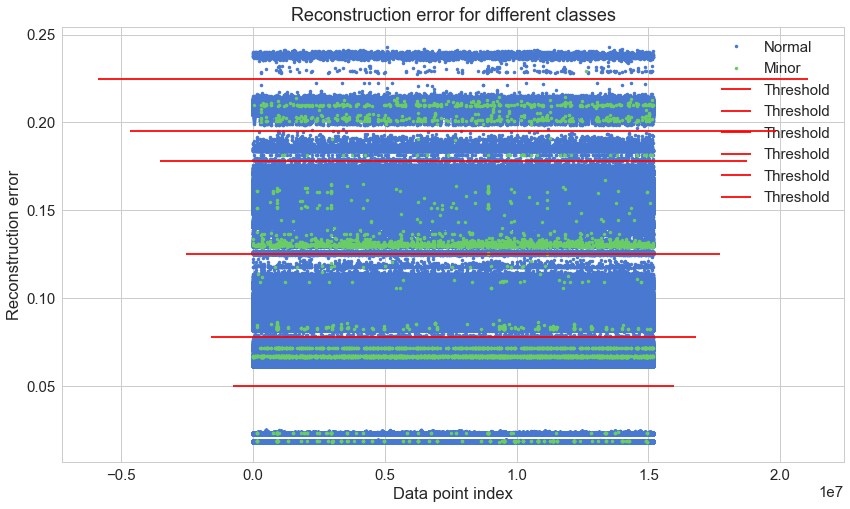

In [10]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Minor" if name == 1 else "Normal")
for threshold in thresholds:
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [11]:
error_df['id'] = pd.Series(ids)

In [28]:
thresholds = [0, 0.05, 0.078, 0.125, 0.178, 0.195, 0.225, 0.25]

cluster1 = error_df[error_df.reconstruction_error < 0.02]

#for i in range(len(thresholds)-1):
 #   clusters.append(np.where(thresholds[i] <= error_df.reconstruction_error 
  #                           & error_df.reconstruction_error < thresholds[i+1]))

In [13]:
transactions = pd.read_csv('data/transactions_all_features.csv')

In [29]:
group1 = transactions.merge(cluster1, left_on='TRANSACTION_ID', right_on='id', how='inner')

In [30]:
del group1['Unnamed: 0']
del group1['id']

In [31]:
group1.columns

Index(['TRANSACTION_ID', 'TRANSACTION_AMOUNT', 'Label', 'CUSTOMER_RISK_SCORE',
       'ACCOUNT_BALANCE', 'Sanction', 'TRANSACTION_TYPE_charge',
       'TRANSACTION_TYPE_electronic transfer',
       'TRANSACTION_TYPE_paper transfer', 'TRANSACTION_TYPE_pos',
       'TRANSACTION_TYPE_withdrawal', 'TRANSACTION_SOURCE_ach credit',
       'TRANSACTION_SOURCE_ach debit', 'TRANSACTION_SOURCE_atm',
       'TRANSACTION_SOURCE_merchant location', 'TRANSACTION_SOURCE_online',
       'TRANSACTION_SOURCE_p2p', 'TRANSACTION_SOURCE_swift',
       'TRANSACTION_SOURCE_teller', 'CUSTOMER_TYPE_Business',
       'CUSTOMER_TYPE_Individual', 'ACCOUNT_TYPE_basic checkings account',
       'ACCOUNT_TYPE_interest checking account', 'reconstruction_error',
       'true_class'],
      dtype='object')

In [33]:
reduced_features1 = ['TRANSACTION_AMOUNT',
                     'CUSTOMER_RISK_SCORE',
                     'ACCOUNT_BALANCE',
                     #'TRANSACTION_TYPE_withdrawal',
                     #'TRANSACTION_SOURCE_atm',
                     #'CUSTOMER_TYPE_Individual',
                     #'ACCOUNT_TYPE_basic checkings account',
                     #'ACCOUNT_TYPE_interest checking account', 
                     'reconstruction_error']

In [34]:
reduced_group1 = group1[reduced_features1]

In [35]:
labels_group1 = group1['Label']
ids_group1 = group1['TRANSACTION_ID']

In [36]:
len(reduced_group1.columns)

4

In [37]:
input_layer = Input(shape=(4, ))
encoder = Dense(3, activation="tanh")(input_layer)
encoder = Dense(2, activation="relu")(encoder)

decoder = Dense(3, activation='tanh')(encoder)
decoder = Dense(4, activation='tanh')(encoder)

autoencoder1 = Model(inputs=input_layer, outputs=decoder)

In [38]:
from keras import optimizers
adam = optimizers.Adam(lr=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.1)

autoencoder1.compile(optimizer=adam, loss='mean_squared_error')

In [39]:
reduce_group1_train = reduced_group1.values

In [40]:
nb_epoch = 1
batch_size = 32
checkpointer = ModelCheckpoint(filepath="model_small1.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder1.fit(reduce_group1_train, reduce_group1_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 2935093 samples, validate on 733774 samples
Epoch 1/1
2935093/2935093 [==============================] - 67s - loss: 1.8486e-04 - val_loss: 2.0864e-05

In [41]:
predictions_group1 = autoencoder1.predict(reduce_group1_train)
mse = np.mean(np.power(reduce_group1_train - predictions_group1, 2), axis=1)
error_df_1 = pd.DataFrame({'reconstruction_error': mse, 'true_class': labels_group1})

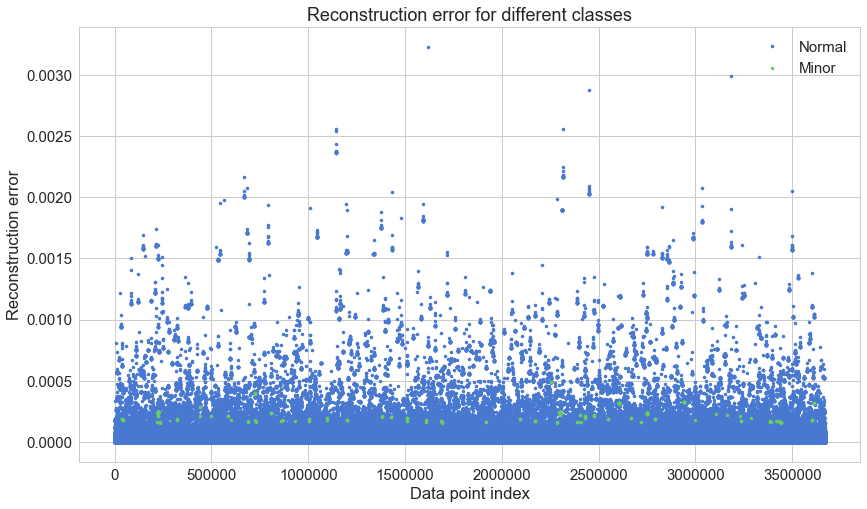

In [42]:
groups = error_df_1.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Minor" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
# compare minor feature values with mean values of the group

In [ ]:
thresholds = [0, 0.05, 0.078, 0.125, 0.178, 0.195, 0.225, 0.25]

cluster2 = error_df[(error_df.reconstruction_error >= 0.05) & (error_df.reconstruction_error < 0.078)]

group2 = transactions.merge(cluster2, left_on='TRANSACTION_ID', right_on='id', how='inner')

del group2['Unnamed: 0']
del group2['id']
group2.columns

In [ ]:
reduced_features2 = ['TRANSACTION_AMOUNT',
                     'CUSTOMER_RISK_SCORE',
                     'ACCOUNT_BALANCE',
                     'Sanction',
                     'TRANSACTION_TYPE_paper transfer',
                     'TRANSACTION_TYPE_withdrawal',
                     'TRANSACTION_SOURCE_atm',
                     'TRANSACTION_SOURCE_merchant location',
                     'CUSTOMER_TYPE_Individual',
                     'ACCOUNT_TYPE_basic checkings account',
                     'ACCOUNT_TYPE_interest checking account', 
                     'reconstruction_error']
reduced_group2 = group2[reduced_features2]
labels_group2 = group2['Label']
ids_group2 = group2['TRANSACTION_ID']
len(reduced_group2.columns)

In [ ]:
input_layer = Input(shape=(12, ))
encoder = Dense(10, activation="tanh")(input_layer)
encoder = Dense(8, activation="tanh")(encoder)
encoder = Dense(6, activation="tanh")(encoder)
encoder = Dense(4, activation="tanh")(encoder)
encoder = Dense(2, activation="relu")(encoder)

decoder = Dense(4, activation='tanh')(encoder)
decoder = Dense(6, activation='tanh')(encoder)
decoder = Dense(8, activation='tanh')(decoder)
decoder = Dense(10, activation='tanh')(decoder)
decoder = Dense(12, activation='relu')(encoder)

autoencoder2 = Model(inputs=input_layer, outputs=decoder)

from keras import optimizers
adam = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.1)

autoencoder2.compile(optimizer=adam, loss='mean_squared_error')

reduce_group2_train = reduced_group2.values

In [ ]:
nb_epoch = 3
batch_size = 32
checkpointer = ModelCheckpoint(filepath="model_small2.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder2.fit(reduce_group2_train, reduce_group2_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

In [ ]:
predictions_group2 = autoencoder2.predict(reduce_group2_train)
mse = np.mean(np.power(reduce_group2_train - predictions_group2, 2), axis=1)
error_df_2 = pd.DataFrame({'reconstruction_error': mse, 'true_class': labels_group2})
error_df_2.describe()

In [ ]:
groups = error_df_2.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Minor" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
threshold = 0.3

from sklearn.metrics import confusion_matrix
y_pred_2 = [1 if e > threshold else 0 for e in error_df_2.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_2.true_class, y_pred_2)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=[0, 1], yticklabels=[0, 1], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
thresholds = [0, 0.05, 0.078, 0.125, 0.178, 0.195, 0.225, 0.25]

cluster3 = error_df[(error_df.reconstruction_error >= 0.078) & (error_df.reconstruction_error < 0.125)]

group3 = transactions.merge(cluster3, left_on='TRANSACTION_ID', right_on='id', how='inner')

del group3['Unnamed: 0']
del group3['id']
group3.columns

In [ ]:
reduced_features3 = ['TRANSACTION_AMOUNT',
                     'CUSTOMER_RISK_SCORE',
                     'ACCOUNT_BALANCE',
                     'Sanction',
                     'TRANSACTION_TYPE_charge',
                     'TRANSACTION_TYPE_electronic transfer',
                     'TRANSACTION_TYPE_paper transfer',
                     'TRANSACTION_TYPE_pos',
                     'TRANSACTION_TYPE_withdrawal',
                     'TRANSACTION_SOURCE_ach credit',
                     'TRANSACTION_SOURCE_ach debit',
                     'TRANSACTION_SOURCE_atm',
                     'TRANSACTION_SOURCE_merchant location',
                     'TRANSACTION_SOURCE_online',
                     'TRANSACTION_SOURCE_p2p',
                     'TRANSACTION_SOURCE_swift',
                     'TRANSACTION_SOURCE_teller',
                     'CUSTOMER_TYPE_Business',
                     'CUSTOMER_TYPE_Individual',
                     'ACCOUNT_TYPE_basic checkings account',
                     'ACCOUNT_TYPE_interest checking account', 
                     'reconstruction_error']
reduced_group3 = group3[reduced_features3]
labels_group3 = group3['Label']
ids_group3 = group3['TRANSACTION_ID']
len(reduced_group3.columns)

In [ ]:
input_layer = Input(shape=(22, ))
encoder = Dense(20, activation="tanh")(input_layer)
encoder = Dense(18, activation="tanh")(encoder)
encoder = Dense(16, activation="tanh")(encoder)
encoder = Dense(14, activation="tanh")(encoder)
encoder = Dense(12, activation="tanh")(encoder)
encoder = Dense(10, activation="tanh")(encoder)
encoder = Dense(8, activation="tanh")(encoder)
encoder = Dense(6, activation="tanh")(encoder)
encoder = Dense(4, activation="tanh")(encoder)
encoder = Dense(2, activation="relu")(encoder)

decoder = Dense(4, activation='tanh')(encoder)
decoder = Dense(6, activation='tanh')(encoder)
decoder = Dense(8, activation='tanh')(decoder)
decoder = Dense(10, activation='tanh')(encoder)
decoder = Dense(12, activation='tanh')(decoder)
decoder = Dense(14, activation='tanh')(encoder)
decoder = Dense(16, activation='tanh')(decoder)
decoder = Dense(18, activation='tanh')(encoder)
decoder = Dense(20, activation='tanh')(encoder)
decoder = Dense(22, activation='relu')(decoder)

autoencoder3 = Model(inputs=input_layer, outputs=decoder)

from keras import optimizers
adam = optimizers.Adam(lr=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.1)

autoencoder3.compile(optimizer=adam, loss='mean_squared_error')

reduce_group3_train = reduced_group3.values

In [ ]:
nb_epoch = 1
batch_size = 32
checkpointer = ModelCheckpoint(filepath="model_small3.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder3.fit(reduce_group3_train, reduce_group3_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

In [ ]:
predictions_group3 = autoencoder3.predict(reduce_group3_train)
mse = np.mean(np.power(reduce_group3_train - predictions_group3, 2), axis=1)
error_df_3 = pd.DataFrame({'reconstruction_error': mse, 'true_class': labels_group3})
error_df_3.describe()

In [ ]:
groups = error_df_3.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Minor" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
thresholds = [0, 0.05, 0.078, 0.125, 0.178, 0.195, 0.225, 0.25]

cluster4 = error_df[(error_df.reconstruction_error >= 0.125) & (error_df.reconstruction_error < 0.178)]

group4 = transactions.merge(cluster4, left_on='TRANSACTION_ID', right_on='id', how='inner')

del group4['Unnamed: 0']
del group4['id']
group4.columns

In [ ]:
reduced_features4 = ['TRANSACTION_AMOUNT',
                     'CUSTOMER_RISK_SCORE',
                     'ACCOUNT_BALANCE',
                     'Sanction',
                     'TRANSACTION_TYPE_charge',
                     'TRANSACTION_TYPE_electronic transfer',
                     'TRANSACTION_TYPE_paper transfer',
                     'TRANSACTION_TYPE_pos',
                     'TRANSACTION_TYPE_withdrawal',
                     'TRANSACTION_SOURCE_ach credit',
                     'TRANSACTION_SOURCE_ach debit',
                     'TRANSACTION_SOURCE_atm',
                     'TRANSACTION_SOURCE_merchant location',
                     'TRANSACTION_SOURCE_online',
                     'TRANSACTION_SOURCE_p2p',
                     'TRANSACTION_SOURCE_swift',
                     'TRANSACTION_SOURCE_teller',
                     'CUSTOMER_TYPE_Business',
                     'CUSTOMER_TYPE_Individual',
                     'ACCOUNT_TYPE_basic checkings account',
                     'ACCOUNT_TYPE_interest checking account', 
                     'reconstruction_error']
reduced_group4 = group4[reduced_features4]
labels_group4 = group4['Label']
ids_group4 = group4['TRANSACTION_ID']
len(reduced_group4.columns)

In [ ]:
input_layer = Input(shape=(22, ))
encoder = Dense(20, activation="tanh")(input_layer)
encoder = Dense(18, activation="tanh")(encoder)
encoder = Dense(16, activation="tanh")(encoder)
encoder = Dense(14, activation="tanh")(encoder)
encoder = Dense(12, activation="tanh")(encoder)
encoder = Dense(10, activation="tanh")(encoder)
encoder = Dense(8, activation="tanh")(encoder)
encoder = Dense(6, activation="tanh")(encoder)
encoder = Dense(4, activation="tanh")(encoder)
encoder = Dense(2, activation="relu")(encoder)

decoder = Dense(4, activation='tanh')(encoder)
decoder = Dense(6, activation='tanh')(encoder)
decoder = Dense(8, activation='tanh')(decoder)
decoder = Dense(10, activation='tanh')(encoder)
decoder = Dense(12, activation='tanh')(decoder)
decoder = Dense(14, activation='tanh')(encoder)
decoder = Dense(16, activation='tanh')(decoder)
decoder = Dense(18, activation='tanh')(encoder)
decoder = Dense(20, activation='tanh')(encoder)
decoder = Dense(22, activation='relu')(decoder)

autoencoder4 = Model(inputs=input_layer, outputs=decoder)

from keras import optimizers
adam = optimizers.Adam(lr=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.1)

autoencoder4.compile(optimizer=adam, loss='mean_squared_error')

reduce_group4_train = reduced_group4.values

In [ ]:
nb_epoch = 1
batch_size = 32
checkpointer = ModelCheckpoint(filepath="model_small4.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder4.fit(reduce_group4_train, reduce_group4_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

In [ ]:
predictions_group4 = autoencoder4.predict(reduce_group4_train)
mse = np.mean(np.power(reduce_group4_train - predictions_group4, 2), axis=1)
error_df_4 = pd.DataFrame({'reconstruction_error': mse, 'true_class': labels_group4})

In [ ]:
groups = error_df_4.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Minor" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
threshold = 0.175

from sklearn.metrics import confusion_matrix
y_pred_4 = [1 if e > threshold else 0 for e in error_df_4.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_4.true_class, y_pred_4)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=[0, 1], yticklabels=[0, 1], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
thresholds = [0, 0.05, 0.078, 0.125, 0.178, 0.195, 0.225, 0.25]

cluster5 = error_df[(error_df.reconstruction_error >= 0.178) & (error_df.reconstruction_error < 0.195)]

group5 = transactions.merge(cluster5, left_on='TRANSACTION_ID', right_on='id', how='inner')

del group5['Unnamed: 0']
del group5['id']
group5.columns

In [ ]:
reduced_features5 = ['TRANSACTION_AMOUNT',
                     'CUSTOMER_RISK_SCORE',
                     'ACCOUNT_BALANCE',
                     'Sanction',
                     'TRANSACTION_TYPE_charge',
                     'TRANSACTION_TYPE_electronic transfer',
                     'TRANSACTION_TYPE_paper transfer',
                     'TRANSACTION_TYPE_pos',
                     'TRANSACTION_TYPE_withdrawal',
                     'TRANSACTION_SOURCE_atm',
                     'TRANSACTION_SOURCE_merchant location',
                     'TRANSACTION_SOURCE_online',
                     'TRANSACTION_SOURCE_p2p',
                     'TRANSACTION_SOURCE_swift',
                     'TRANSACTION_SOURCE_teller',
                     'CUSTOMER_TYPE_Business',
                     'CUSTOMER_TYPE_Individual',
                     'ACCOUNT_TYPE_basic checkings account',
                     'ACCOUNT_TYPE_interest checking account', 
                     'reconstruction_error']
reduced_group5 = group5[reduced_features5]
labels_group5 = group5['Label']
ids_group5 = group5['TRANSACTION_ID']
len(reduced_group5.columns)

In [ ]:
input_layer = Input(shape=(20, ))
encoder = Dense(18, activation="tanh")(input_layer)
encoder = Dense(16, activation="tanh")(encoder)
encoder = Dense(14, activation="tanh")(encoder)
encoder = Dense(12, activation="tanh")(encoder)
encoder = Dense(10, activation="tanh")(encoder)
encoder = Dense(8, activation="tanh")(encoder)
encoder = Dense(6, activation="tanh")(encoder)
encoder = Dense(4, activation="tanh")(encoder)
encoder = Dense(2, activation="relu")(encoder)

decoder = Dense(4, activation='tanh')(encoder)
decoder = Dense(6, activation='tanh')(encoder)
decoder = Dense(8, activation='tanh')(decoder)
decoder = Dense(10, activation='tanh')(encoder)
decoder = Dense(12, activation='tanh')(decoder)
decoder = Dense(14, activation='tanh')(encoder)
decoder = Dense(16, activation='tanh')(decoder)
decoder = Dense(18, activation='tanh')(encoder)
decoder = Dense(20, activation='tanh')(encoder)

autoencoder5 = Model(inputs=input_layer, outputs=decoder)

from keras import optimizers
adam = optimizers.Adam(lr=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.1)

autoencoder5.compile(optimizer=adam, loss='mean_squared_error')

reduce_group5_train = reduced_group5.values

In [ ]:
nb_epoch = 3
batch_size = 16
checkpointer = ModelCheckpoint(filepath="model_small5.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder5.fit(reduce_group5_train, reduce_group5_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

In [ ]:
predictions_group5 = autoencoder5.predict(reduce_group5_train)
mse = np.mean(np.power(reduce_group5_train - predictions_group5, 2), axis=1)
error_df_5 = pd.DataFrame({'reconstruction_error': mse, 'true_class': labels_group5})

In [ ]:
groups = error_df_5.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Minor" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
threshold = 0.10

from sklearn.metrics import confusion_matrix
y_pred_5 = [1 if e > threshold else 0 for e in error_df_5.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_5.true_class, y_pred_5)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=[0, 1], yticklabels=[0, 1], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
thresholds = [0, 0.05, 0.078, 0.125, 0.178, 0.195, 0.225, 0.25]

cluster6 = error_df[(error_df.reconstruction_error >= 0.195) & (error_df.reconstruction_error < 0.225)]

group6 = transactions.merge(cluster6, left_on='TRANSACTION_ID', right_on='id', how='inner')

del group6['Unnamed: 0']
del group6['id']
group6.columns

In [ ]:
reduced_features6 = ['TRANSACTION_AMOUNT',
                     'CUSTOMER_RISK_SCORE',
                     'ACCOUNT_BALANCE',
                     'Sanction',
                     'TRANSACTION_TYPE_charge',
                     'TRANSACTION_TYPE_electronic transfer',
                     'TRANSACTION_TYPE_paper transfer',
                     'TRANSACTION_TYPE_pos',
                     'TRANSACTION_SOURCE_ach credit',
                     'TRANSACTION_SOURCE_ach debit',
                     'TRANSACTION_SOURCE_merchant location',
                     'TRANSACTION_SOURCE_online',
                     'TRANSACTION_SOURCE_p2p',
                     'TRANSACTION_SOURCE_swift',
                     'TRANSACTION_SOURCE_teller',
                     'CUSTOMER_TYPE_Business',
                     'CUSTOMER_TYPE_Individual',
                     'ACCOUNT_TYPE_basic checkings account',
                     'ACCOUNT_TYPE_interest checking account', 
                     'reconstruction_error']
reduced_group6 = group6[reduced_features6]
labels_group6 = group6['Label']
ids_group6 = group6['TRANSACTION_ID']
len(reduced_group6.columns)

In [ ]:
input_layer = Input(shape=(20, ))
encoder = Dense(18, activation="tanh")(input_layer)
encoder = Dense(16, activation="tanh")(encoder)
encoder = Dense(14, activation="tanh")(encoder)
encoder = Dense(12, activation="tanh")(encoder)
encoder = Dense(10, activation="tanh")(encoder)
encoder = Dense(8, activation="tanh")(encoder)
encoder = Dense(6, activation="tanh")(encoder)
encoder = Dense(4, activation="tanh")(encoder)
encoder = Dense(2, activation="relu")(encoder)

decoder = Dense(4, activation='tanh')(encoder)
decoder = Dense(6, activation='tanh')(encoder)
decoder = Dense(8, activation='tanh')(decoder)
decoder = Dense(10, activation='tanh')(encoder)
decoder = Dense(12, activation='tanh')(decoder)
decoder = Dense(14, activation='tanh')(encoder)
decoder = Dense(16, activation='tanh')(decoder)
decoder = Dense(18, activation='tanh')(encoder)
decoder = Dense(20, activation='tanh')(encoder)

autoencoder6 = Model(inputs=input_layer, outputs=decoder)

from keras import optimizers
adam = optimizers.Adam(lr=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.1)

autoencoder6.compile(optimizer=adam, loss='mean_squared_error')

reduce_group6_train = reduced_group6.values

In [ ]:
nb_epoch = 3
batch_size = 16
checkpointer = ModelCheckpoint(filepath="model_small6.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder6.fit(reduce_group6_train, reduce_group6_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

In [ ]:
predictions_group6 = autoencoder6.predict(reduce_group6_train)
mse = np.mean(np.power(reduce_group6_train - predictions_group6, 2), axis=1)
error_df_6 = pd.DataFrame({'reconstruction_error': mse, 'true_class': labels_group6})

In [ ]:
groups = error_df_6.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Minor" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
threshold = 0.13

from sklearn.metrics import confusion_matrix
y_pred_6 = [1 if e > threshold else 0 for e in error_df_6.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_6.true_class, y_pred_6)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=[0, 1], yticklabels=[0, 1], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
thresholds = [0, 0.05, 0.078, 0.125, 0.178, 0.195, 0.225, 0.25]

cluster7 = error_df[(error_df.reconstruction_error >= 0.225) & (error_df.reconstruction_error < 0.25)]

group7 = transactions.merge(cluster7, left_on='TRANSACTION_ID', right_on='id', how='inner')

del group7['Unnamed: 0']
del group7['id']
group7.columns

In [ ]:
reduced_features7 = ['TRANSACTION_AMOUNT',
                     'CUSTOMER_RISK_SCORE',
                     'ACCOUNT_BALANCE',
                     'Sanction',
                     'TRANSACTION_TYPE_electronic transfer',
                     'TRANSACTION_SOURCE_swift',
                     'CUSTOMER_TYPE_Business',
                     'CUSTOMER_TYPE_Individual',
                     'ACCOUNT_TYPE_basic checkings account',
                     'ACCOUNT_TYPE_interest checking account', 
                     'reconstruction_error']
reduced_group7 = group7[reduced_features7]
labels_group7 = group7['Label']
ids_group7 = group7['TRANSACTION_ID']
len(reduced_group7.columns)

In [ ]:
input_layer = Input(shape=(11, ))
encoder = Dense(10, activation="tanh")(input_layer)
encoder = Dense(8, activation="tanh")(encoder)
encoder = Dense(6, activation="tanh")(encoder)
encoder = Dense(4, activation="tanh")(encoder)
encoder = Dense(2, activation="relu")(encoder)

decoder = Dense(4, activation='tanh')(encoder)
decoder = Dense(6, activation='tanh')(encoder)
decoder = Dense(8, activation='tanh')(decoder)
decoder = Dense(10, activation='tanh')(encoder)
decoder = Dense(11, activation='tanh')(encoder)

autoencoder7 = Model(inputs=input_layer, outputs=decoder)

from keras import optimizers
adam = optimizers.Adam(lr=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.1)

autoencoder7.compile(optimizer=adam, loss='mean_squared_error')

reduce_group7_train = reduced_group7.values

In [ ]:
nb_epoch = 10
batch_size = 16
checkpointer = ModelCheckpoint(filepath="model_small7.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder7.fit(reduce_group7_train, reduce_group7_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

In [ ]:
predictions_group7 = autoencoder7.predict(reduce_group7_train)
mse = np.mean(np.power(reduce_group7_train - predictions_group7, 2), axis=1)
error_df_7 = pd.DataFrame({'reconstruction_error': mse, 'true_class': labels_group7})

In [ ]:
groups = error_df_7.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Minor" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();